Fitting 10 folds for each of 74 candidates, totalling 740 fits
Melhor modelo e parâmetros:
Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200))])
Acurácia média (CV): 0.8943308007013442
Acurácia no teste: 0.9132653061224489

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       120
           1       0.90      0.87      0.89        76

    accuracy                           0.91       196
   macro avg       0.91      0.91      0.91       196
weighted avg       0.91      0.91      0.91       196



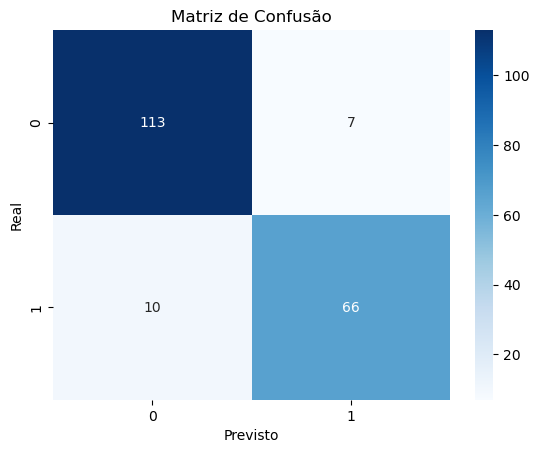

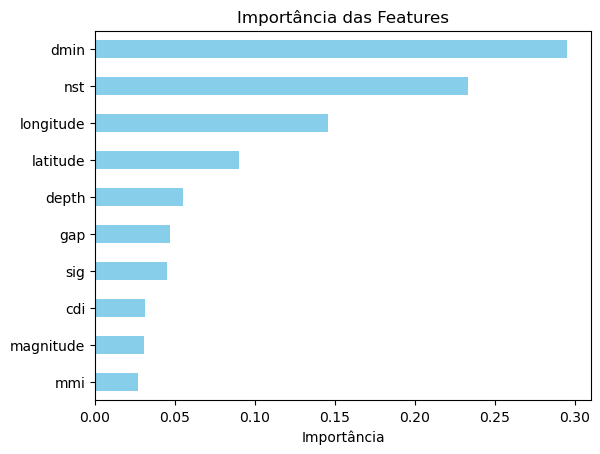

{'Previsão (0=não,1=tsunami)': 1, 'Probabilidade': 0.5343370795870795}


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

class AlertaTsunamiML:
    def __init__(self, df, target='tsunami', test_size=0.25, random_state=32):
        self.df = df.copy()
        self.target = target
        self.test_size = test_size
        self.random_state = random_state
        self.modelo_otimo = None
        self.Xtrain = self.Xtest = self.ytrain = self.ytest = None
        
        # Separar features e target
        self.X = self.df.drop([target, 'Year', 'Month'], axis=1)
        self.y = self.df[target]
        
        # Divisão treino/teste
        self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(
            self.X, self.y, test_size=self.test_size,
            random_state=self.random_state, stratify=self.y
        )

        # Pipeline genérico
        self.pipe = Pipeline([
            ('scaler', RobustScaler()),
            ('model', RandomForestClassifier())
        ])

        # Grid de hiperparâmetros
        self.param_grid = [
            {'model': [RandomForestClassifier()],
             'model__n_estimators': [100, 200, 500],
             'model__max_depth': [None, 5, 10],
             'model__min_samples_split': [2, 5]},
            {'model': [SVC()],
             'model__C': [0.1, 1, 5, 10],
             'model__kernel': ['linear', 'rbf', 'poly'],
             'model__gamma': ['scale', 'auto']},
            {'model': [GradientBoostingClassifier()],
             'model__n_estimators': [100, 200],
             'model__learning_rate': [0.01, 0.1, 0.2],
             'model__max_depth': [3, 5]},
            {'model': [LogisticRegression(max_iter=1000)],
             'model__C': [0.01, 0.1, 1, 10],
             'model__penalty': ['l2'],
             'model__solver': ['lbfgs']},
            {'model': [KNeighborsClassifier()],
             'model__n_neighbors': [3, 5, 7, 9],
             'model__weights': ['uniform', 'distance'],
             'model__metric': ['euclidean', 'manhattan']}
        ]
    
    def treinar(self, cv=10, verbose=2, n_jobs=-1):
        search = GridSearchCV(self.pipe, self.param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
        search.fit(self.Xtrain, self.ytrain)
        self.modelo_otimo = search.best_estimator_
        print("Melhor modelo e parâmetros:")
        print(self.modelo_otimo)
        print("Acurácia média (CV):", search.best_score_)
        return self.modelo_otimo

    def avaliar(self):
        if self.modelo_otimo is None:
            raise Exception("Treine o modelo antes de avaliar.")
        y_pred = self.modelo_otimo.predict(self.Xtest)
        print("Acurácia no teste:", self.modelo_otimo.score(self.Xtest, self.ytest))
        print("\nClassification Report:\n", classification_report(self.ytest, y_pred))
        cm = confusion_matrix(self.ytest, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.title('Matriz de Confusão')
        plt.show()

    def importancia_features(self):
        if self.modelo_otimo is None:
            raise Exception("Treine o modelo antes de extrair importâncias.")
        importances = self.modelo_otimo.named_steps['model'].feature_importances_
        feat_importances = pd.Series(importances, index=self.Xtrain.columns)
        feat_importances.sort_values().plot(kind='barh', color='skyblue')
        plt.title('Importância das Features')
        plt.xlabel('Importância')
        plt.show()
        return feat_importances

    def prever(self, novo_evento):
        if self.modelo_otimo is None:
            raise Exception("Treine o modelo antes de prever.")
        # Suporta dict ou DataFrame
        if isinstance(novo_evento, dict):
            novo_evento = pd.DataFrame([novo_evento])
        pred = self.modelo_otimo.predict(novo_evento)[0]
        prob = self.modelo_otimo.predict_proba(novo_evento)[0][1] if hasattr(self.modelo_otimo.named_steps['model'], "predict_proba") else None
        return {"Previsão (0=não,1=tsunami)": pred, "Probabilidade": prob}

# --- USO ---
df = pd.read_csv("earthquake_data_tsunami.csv")
alerta = AlertaTsunamiML(df)
alerta.treinar()  # Treinar e buscar melhor modelo
alerta.avaliar()   # Avaliar desempenho no teste
alerta.importancia_features()  # Plotar importância das features

# Exemplo de previsão para novo terremoto
novo_terremoto = {
    "magnitude": 7.8,
    "cdi": 8,
    "mmi": 7,
    "sig": 1800,
    "nst": 100,
    "dmin": 2.5,
    "gap": 30,
    "depth": 15,
    "latitude": -3.2,
    "longitude": 120.5
}
resultado = alerta.prever(novo_terremoto)
print(resultado)
